In [1]:
import numpy as np
from quantecon.optimize import brent_max, brentq
from collections import namedtuple
from numba import njit
import matplotlib.pyplot as plt
from scipy.optimize import root, minimize
from quantecon.distributions import BetaBinomial

## Q1

### (a)

$$
MR\left(q\right)=a+2bq \\
MC\left(q\right)=c_{1}\exp\left(q\right)
$$

In [2]:
ModelMonopoly = namedtuple("Model", ("a", "b", "c1"))

def create_monopoly_model(a=200, b=-1, c1=1):
    return ModelMonopoly(a=a, b=b, c1=c1)

In [3]:
model_mono = create_monopoly_model()

model_mono

Model(a=200, b=-1, c1=1)

In [4]:
@njit
def MR(q, model):
    a, b, c1 = model.a, model.b, model.c1

    return a + 2 * b * q

@njit
def MC(q, model):
    a, b, c1 = model.a, model.b, model.c1

    return c1 * np.exp(q)

Text(0, 0.5, 'MR/MC')

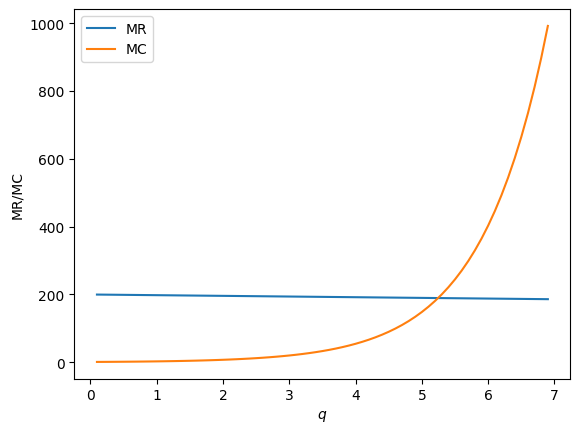

In [5]:
q_range = np.arange(0.1, 7, 0.1)

plt.plot(q_range, MR(q_range, model_mono), label='MR')
plt.plot(q_range, MC(q_range, model_mono), label='MC')

plt.legend()
plt.xlabel('$q$')
plt.ylabel('MR/MC')

### (a*) plot with jax.grad

In [6]:
@njit
def π(q, model):

    a, b, c1 = model.a, model.b, model.c1

    R = (a + b * q) * q
    VC = c1 * np.exp(q)   # variant cost

    return R - VC

In [7]:
brent_max?

In [8]:
q_min = 4
q_max = 7

brent_max(π, q_min, q_max, args=(model_mono,))

(5.244448553501892, 831.8741889926798, (0, 10))

### (b*) solve MR=MC

In [9]:
brentq(njit(lambda q: MR(q, model_mono) - MC(q, model_mono)),
       q_min, q_max)

results(root=5.24444762308912, function_calls=11, iterations=10, converged=True)

## Q2

### (a)

FOC w.r.t. $h$

$$
w\left(wh+N\right)^{\eta}-\alpha h^{\gamma}=0
$$

### (b)

In [10]:
ModelLaborSupply = namedtuple("Model", ("η", "γ", "α", "w", "N"))

def create_ls_model(η=-0.5, γ=0.25, α=0.75, w=15, N=30):
    return ModelLaborSupply(η=η, γ=γ, α=α, w=w, N=N)

In [11]:
model_ls = create_ls_model()

model_ls

Model(η=-0.5, γ=0.25, α=0.75, w=15, N=30)

In [12]:
@njit
def foc(h, model):
    η, γ, α, w, N = model.η, model.γ, model.α, model.w, model.N

    term1 = w * (w * h + N) ** η
    term2 = α * h ** γ

    return term1 - term2

Text(0, 0.5, 'FOC w.r.t. $h$')

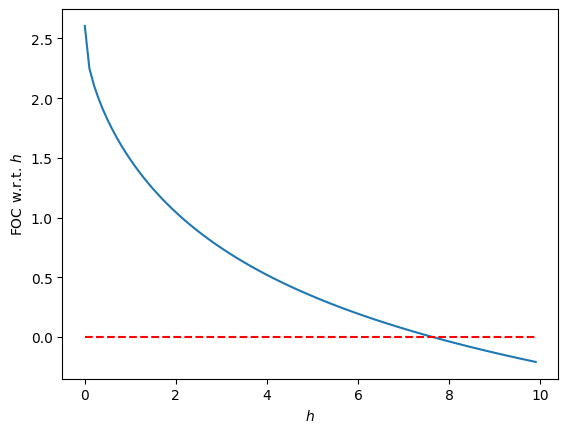

In [13]:
h_range = np.arange(1e-3, 10, 0.1)

plt.plot(h_range, foc(h_range, model_ls))
plt.hlines(0, h_range.min(), h_range.max(), color='r', linestyle='--')

plt.xlabel('$h$')
plt.ylabel('FOC w.r.t. $h$')

In [14]:
brentq(foc, 1e-3, 10, args=(model_ls,))

results(root=7.644697076637788, function_calls=9, iterations=8, converged=True)

## Q3

### (a)

BR1 (given $q_2$):

$$
a+2bq_{1}+bq_{2}-c_{1}\exp\left(q_{1}\right) = 0
$$

BR2 (given $q_1$):

$$
a+2bq_{2}+bq_{1}-c_{1}\exp\left(q_{2}\right) = 0
$$

In [15]:
ModelCournot = namedtuple("Model", ("a", "b", "c1"))

def create_cournot_model(a=200, b=-1, c1=1):
    return ModelCournot(a=a, b=b, c1=c1)

In [16]:
model_cournot = create_cournot_model()

model_cournot

Model(a=200, b=-1, c1=1)

In [17]:
@njit
def q_foc(q, q_opp, model):
    a, b, c1 = model.a, model.b, model.c1

    MR = a + 2 * b * q + b * q_opp
    MC = c1 * np.exp(q)

    return MR - MC

@njit
def q_br(q_opp, model):
    a, b, c1 = model.a, model.b, model.c1

    res = brentq(q_foc, 1e-3, 100, args=(q_opp, model))
    q_opt = res.root

    return q_opt

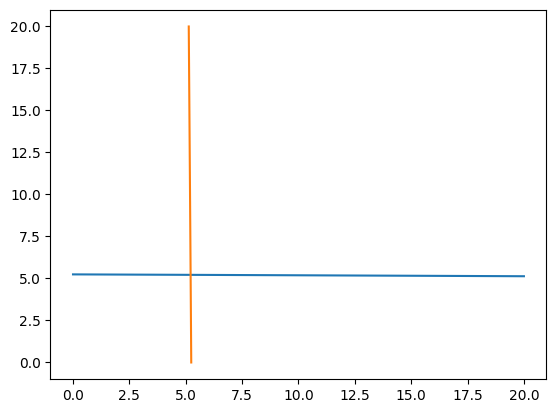

In [18]:
q_range = np.linspace(1e-3, 20, 100)
q_br_arr = [q_br(q_opp, model_cournot) for q_opp in q_range]

plt.plot(q_range, q_br_arr)
plt.plot(q_br_arr, q_range)

### (b)

In [19]:
@njit
def br_eqs(q_vec, model):

    q1, q2 = q_vec
    qs_br = np.array([q_br(q2, model), q_br(q1, model)])

    return qs_br

In [20]:
res = root(njit(lambda q_vec: q_vec - br_eqs(q_vec, model_cournot)),
           x0=np.array([5., 5.]),
           method='hybr')

res

 message: The solution converged.
 success: True
  status: 1
     fun: [ 0.000e+00  0.000e+00]
       x: [ 5.217e+00  5.217e+00]
  method: hybr
    nfev: 6
    fjac: [[-1.000e+00 -5.363e-03]
           [ 5.363e-03 -1.000e+00]]
       r: [-1.000e+00 -1.073e-02 -1.000e+00]
     qtf: [ 2.072e-12  2.049e-12]

In [21]:
res.x

array([5.21683341, 5.21683341])

### (b*) minimize squared difference sum

In [22]:
res = minimize(njit(lambda q_vec: np.sum((q_vec - br_eqs(q_vec, model_cournot)) ** 2)),
               x0=np.array([5., 5.]),
               method='nelder-mead')

res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 8.507230807697257e-10
             x: [ 5.217e+00  5.217e+00]
           nit: 27
          nfev: 53
 final_simplex: (array([[ 5.217e+00,  5.217e+00],
                       [ 5.217e+00,  5.217e+00],
                       [ 5.217e+00,  5.217e+00]]), array([ 8.507e-10,  3.510e-09,  5.874e-09]))

In [23]:
res.x

array([5.21685796, 5.21681739])

## Q4

### (a)

In [24]:
# NamedTuple Model
ModelJobSearch = namedtuple("Model", ("n", "w_vals", "φ", "β", "c", "T"))

def create_job_search_model(
        n=50,        # wage grid size
        w_min=10.0,  # lowest wage
        w_max=60.0,  # highest wage
        a=200,       # wage distribution parameter
        b=100,       # wage distribution parameter
        β=0.96,      # discount factor
        c=10.0,       # unemployment compensation
        T=3
    ):
    """
    Creates the parameters for job search model and returns the
    instance of namedtuple Model
    """
    w_vals = np.linspace(w_min, w_max, n+1)
    φ = BetaBinomial(n, a, b).pdf()
    return ModelJobSearch(n=n, w_vals=w_vals, φ=φ, β=β, c=c, T=T)

In [25]:
model_js = create_job_search_model()

model_js

Model(n=50, w_vals=array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.,
       23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.,
       36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48.,
       49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59., 60.]), φ=array([1.17916374e-21, 7.91385058e-20, 2.63322684e-18, 5.78951642e-17,
       9.45852331e-16, 1.22425907e-14, 1.30715161e-13, 1.18361860e-12,
       9.27411020e-12, 6.38444655e-11, 3.90773732e-10, 2.14682757e-09,
       1.06680218e-08, 4.82546790e-08, 1.99734835e-07, 7.59880083e-07,
       2.66702315e-06, 8.66281202e-06, 2.61087529e-05, 7.31758378e-05,
       1.91073370e-04, 4.65516517e-04, 1.05947988e-03, 2.25461382e-03,
       4.48909716e-03, 8.36624059e-03, 1.45968062e-02, 2.38401316e-02,
       3.64371566e-02, 5.20857161e-02, 6.95778357e-02, 8.67601096e-02,
       1.00844841e-01, 1.09072276e-01, 1.09542415e-01, 1.01894858e-01,
       8.75193404e-02, 6.91614209e-02, 5.00672786e-02, 

In [42]:
@njit
def v_t(w, t, v_next, model):
    """
    Computes lifetime value at t given current wage w_t = w and v_{t+1}
    """
    β, c, T = model.β, model.c, model.T
    h_t = c + β * np.sum(v_next * model.φ)
#     z_t = w * (β ** np.arange(0, T-t+1, 1)).sum()
    z_t = w * (1 - β ** (T-t+1)) / (1 - β)
    return np.maximum(z_t, h_t)

In [43]:
@njit
def backwards_induction(model):

    # unpack parameters
    β, c, T = model.β, model.c, model.T
    w_vals = model.w_vals

    # initialize value function array
    v_arr = np.empty((T+1, model.w_vals.size))

    # compute v(T)
    v_arr[-1] = np.maximum(c, w_vals)

    for t in range(T-1, -1, -1):
        v_arr[t] = [v_t(w, t, v_arr[t+1], model) for w in w_vals]

    return v_arr

### (b)

In [44]:
model_js2 = create_job_search_model(T=2)

In [45]:
v_arr2 = backwards_induction(model_js2)

Text(0.5, 0, 'w')

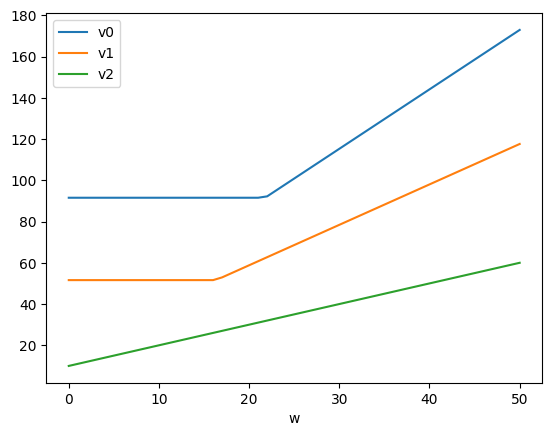

In [46]:
plt.plot(v_arr2.T)

plt.legend(['v0', 'v1', 'v2'])
plt.xlabel('w')

### (c)

In [47]:
model_js9 = create_job_search_model(T=9)

Text(0.5, 0, 'w')

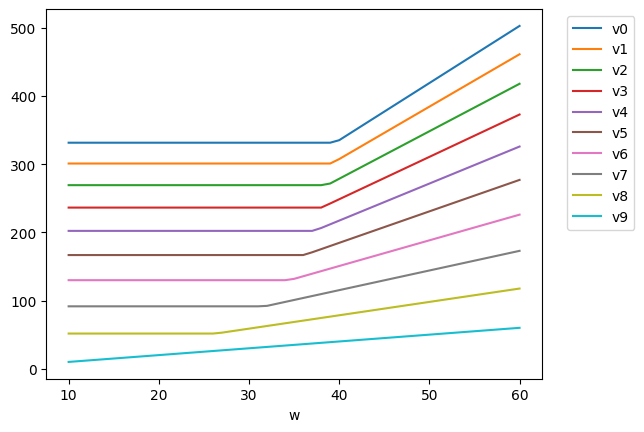

In [59]:
v_arr9 = backwards_induction(model_js9)

plt.plot(model_js9.w_vals, v_arr9.T)

plt.legend(['v'+str(t) for t in range(10)],
           loc='upper right', bbox_to_anchor=(1.2, 1.))
plt.xlabel('w')

In [51]:
@njit
def res_wage_t(t, v_next, model):
    """
    Computes lifetime value at t given current wage w_t = w and v_{t+1}
    """
    β, c, T = model.β, model.c, model.T
    h_t = c + β * np.sum(v_next * model.φ)
    return h_t * (1 - β) / (1 - β ** (T-t+1))

In [64]:
res_wage_seq

array([39.56075563, 39.15295117, 38.65269576, 38.03328107, 37.22553341,
       36.1204253 , 34.48377626, 31.7656874 , 26.32653061,  1.        ])

In [66]:
(model_js9.w_vals >= model_js9.c)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

Text(0.5, 0, 't')

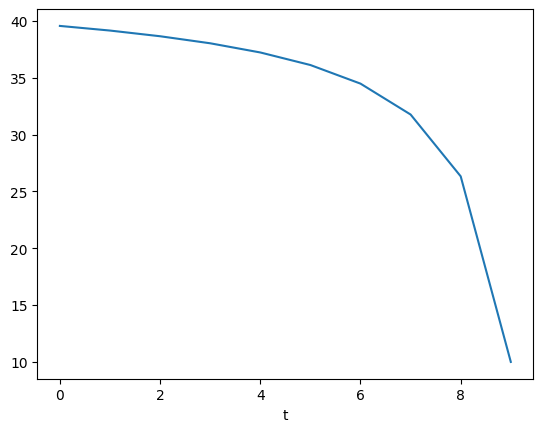

In [68]:
T = model_js9.T

t_range = np.arange(0, T+1, 1)

res_wage_seq = np.empty(T+1)
for t in t_range[:T]:
    res_wage_seq[t] = res_wage_t(t, v_arr9[t+1], model_js9)
res_wage_seq[T] = np.maximum(model_js9.w_vals.min(), model_js9.c)

plt.plot(t_range, res_wage_seq)
plt.xlabel('t')